In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import  SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller

df1 = pd.read_csv('/Users/sahibsingh05/Documents/code/py/United States 10-Year Bond Yield Historical Data (1).csv' , parse_dates= ['Date'] , index_col= 'Date' )
df1.head()
df1.tail()
df_mth = df1.resample('M').mean()

#first step towards model preprocessing phase
#as the seasonal_decompose library has been imported
#will be utilizing it for graphical representation of decomposition

#seasonal_decompose(df_mth.Open).plot()

print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.Open)[1]))

#adfuller value shouldn't be greater than 0.1 for the series to be stationary, but the value is 0.795, so we have to make it stationary

#transforming the data using box-cox transformation

df_mth["close_box"] , lmbda = stats.boxcox(df_mth.Open)
print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.close_box)[1]))

#still not stationary , ADfuller value = 0.742










Augmented Dickey Fuller test value = : 0.7950535215912076
Augmented Dickey Fuller test value = : 0.7425810111289357


/var/folders/rb/v_td1bdn4fb68f69ghqglbpw0000gn/T/ipykernel_38738/3797072613.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mth = df1.resample('M').mean()


In [185]:
#Differencing

# differencing monthly for 12 months

df_mth['diff_12'] = (df_mth.close_box - df_mth.close_box.shift(12))
print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.diff_12[12:])[1]))

# value- 0.604 , not stationary 

#differencing for 3 months

df_mth['diff_3'] = (df_mth.close_box - df_mth.close_box.shift(3))
print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.diff_3[3:])[1]))

#value - 0.233, not stationary

#differencing for 2 months 

df_mth['diff_2'] = (df_mth.close_box - df_mth.close_box.shift(2))
print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.diff_2[2:])[1]))

#value - 0.08 , stationary

Augmented Dickey Fuller test value = : 0.6043633922734731
Augmented Dickey Fuller test value = : 0.23320222294898318
Augmented Dickey Fuller test value = : 0.08702129701004763


Augmented Dickey Fuller test value = : 0.00019695068497069485


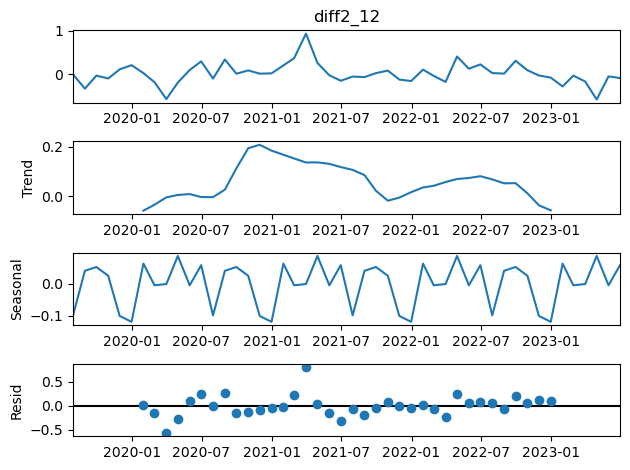

In [186]:
#differencing second time 

df_mth["diff2_12"] = (df_mth.diff_12 - df_mth.diff_12.shift(1))
seasonal_decompose(df_mth.diff2_12[13:]).plot()

print("Augmented Dickey Fuller test value = : " + str(adfuller(df_mth.diff2_12[13:])[1]))


#value = 0.00019 , series stationary

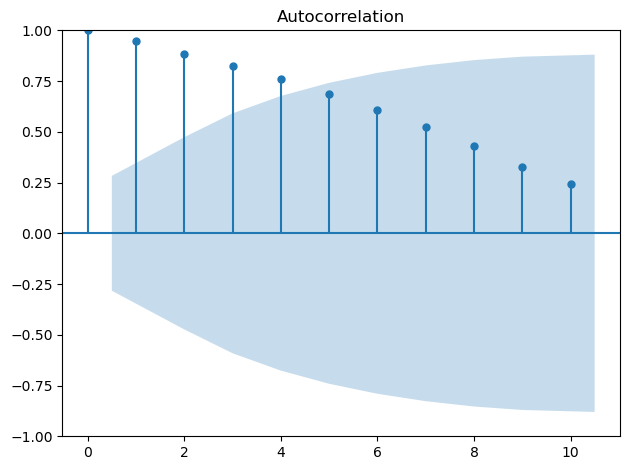

/Users/sahibsingh05/opt/anaconda3/envs/tf/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


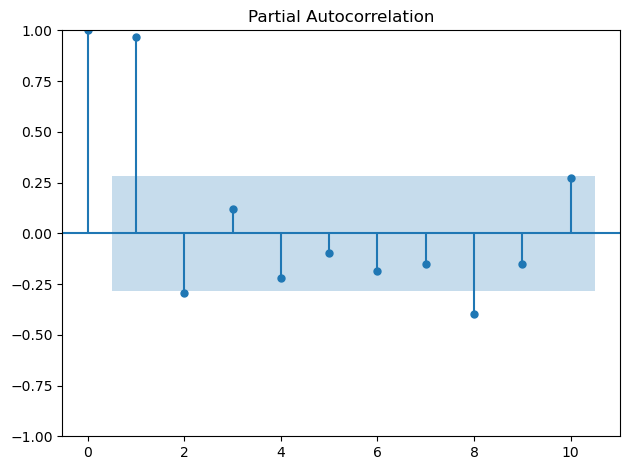

In [187]:
plot_acf(df_mth.Open[13:].values.squeeze() , lags = 10)

plt.tight_layout()
plt.show()

plot_pacf(df_mth.Open[13:].values.squeeze() , lags = 10)
plt.tight_layout()
plt.show()

#acf tails off therefore its AR and PACF cuts-off at lag 3 , therefore p = 3


<Figure size 200x200 with 0 Axes>

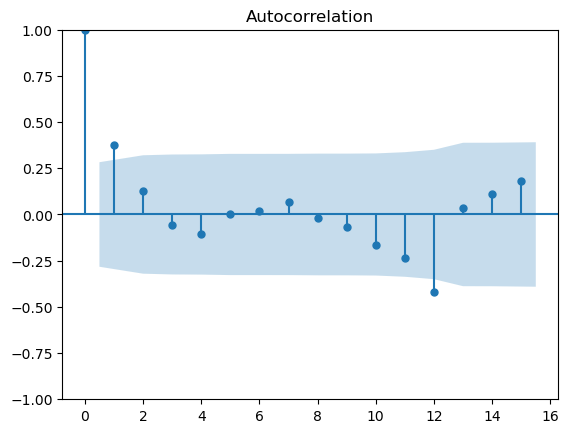

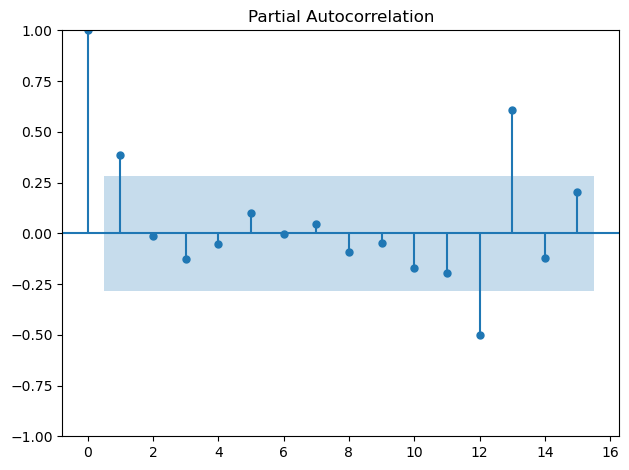

In [188]:
plt.figure(figsize=(2,2))
plot_acf(df_mth.diff2_12[13:].values.squeeze() , lags = 15)
plot_pacf(df_mth.diff2_12[13:].values.squeeze() , lags = 15)
plt.tight_layout()
plt.show()

#PACF trails off and ACF cuts at lag 2 , therefore q = 2



In [198]:
#building ARIMA
from itertools import product


ps = range(0,3)
qs = range(0,2)
d = 1
parameters = product(ps , qs) # gives an array of (x,y) samples
parameters_list = list(parameters)

#selecting best model
res = []
aic_bst = float('inf')
for params in parameters_list:
    try:
        model = SARIMAX(df_mth.close_box , order = (params[0] , d , params[1])).fit(disp=-1)
    except ValueError:
        print('Invalid params :',  params)
        continue
    aic = model.aic #aic is akaike information criterion , in which the model with lowest score is the best 
    #aic = 2k -2L(M)
    if aic< aic_bst:
        aic_bst = aic
        model_bst = model
        param_bst = params
    res.append([params , model.aic])



In [190]:
res_table = pd.DataFrame(res)
res_table.columns = ['Parameters' , 'aic']
print(res_table.sort_values(  by = 'aic',  ascending= True).head())
#all the aic values to get the best model

  Parameters        aic
2     (1, 0) -53.666059
1     (0, 1) -53.657629
4     (2, 0) -52.482414
3     (1, 1) -52.394544
5     (2, 1) -50.482780


In [191]:
print(model_bst)

In [192]:
print("The ADfuller test value is: "+str(adfuller(model_bst.resid[13:])[1]))

#The value of p is way below significance so, good

The ADfuller test value is: 2.8384730399243642e-06


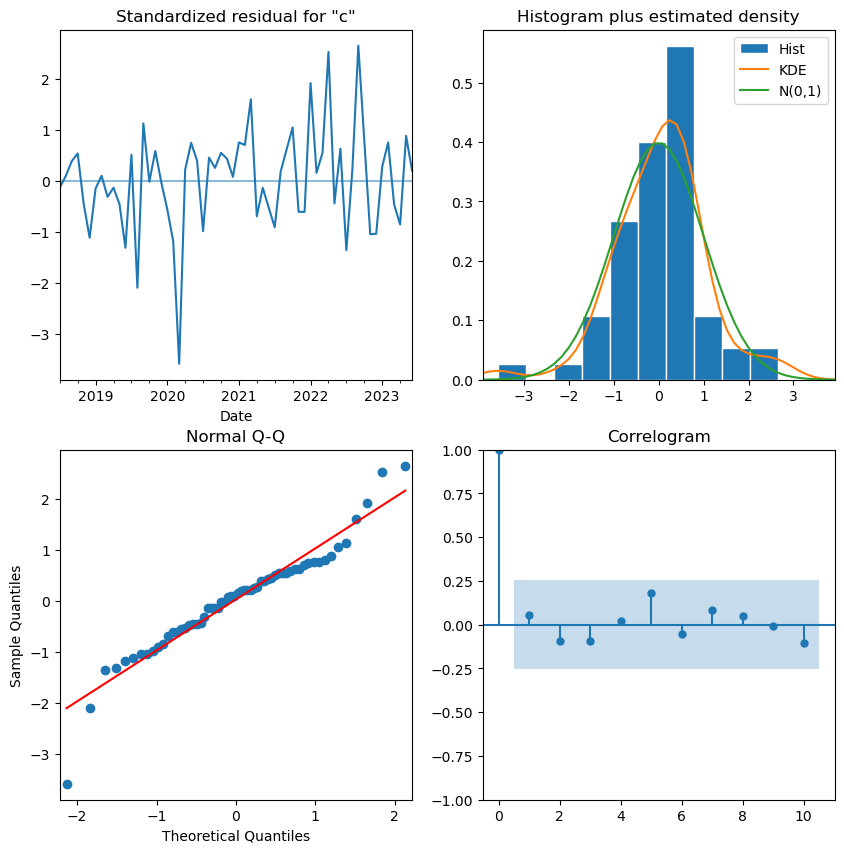

In [193]:
model_bst.plot_diagnostics(figsize=(10,10))
plt.show()

In [326]:
#reverse box cox to bring the prediction back to original scale
def inverseBox(y , lmbda):
    if lmbda == 0:
       return (np.exp(y))
    else:
        return np.exp(np.log(lmbda*y+1)/lmbda)


        # box cox formula - if lmbda != 0 , y = (np.exp(x,lmbda)-1)/lmbda
        # if lmbda = 0 , y = logx


In [327]:
#predicting prices of us bonds 
from datetime import datetime
df_mth_pred = df_mth[['Open']]
date_list = [datetime(2023,7,31),datetime(2023,8,31),datetime(2023,9,30),datetime(2023,10,31),
             datetime(2023,11,30),datetime(2023,12,31)]

future = pd.DataFrame(index = date_list , columns= df_mth.columns)
df_mth_pred = pd.concat([df_mth_pred , future ])

df_mth_pred['forecast'] = inverseBox(model_bst.predict(start= datetime(2018,6,30) , end= datetime(2023,8,30)),lmbda)-1.65



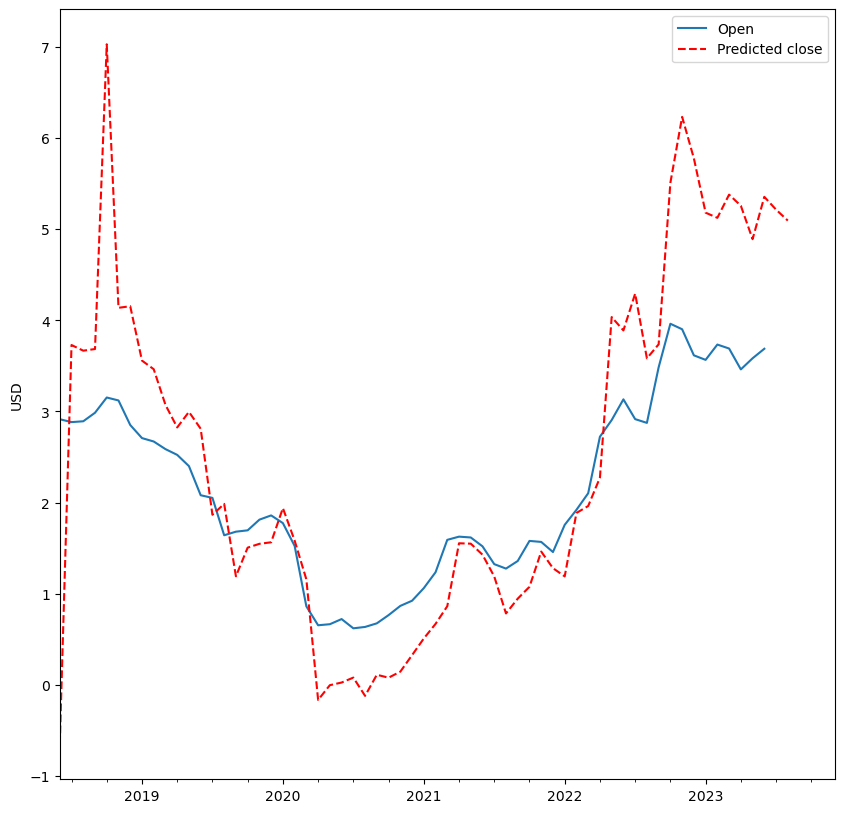

In [325]:
plt.figure(figsize=(10,10))
df_mth_pred.Open.plot()
df_mth_pred.forecast.plot(color= 'r' , ls='--' , label= 'Predicted close'  )
plt.legend()
plt.ylabel('USD')
plt.show()


In [315]:
#sarimax model

Qs = range(0,2)
Ps = range(0,3)
qs = range(0,3)
ps = range(0,3)
D=1
d=1
parameters = product(ps,qs,Ps,Qs)
parameters_list = list(parameters)

res2 = []
aic_bst = float('inf')

for param in parameters_list:
    try:
        model = SARIMAX(df_mth.Open , order=(param[0] , d , param[1]) , seasonal_order=(param[2] , D , param[3],4)).fit(disp=-1)
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic<aic_bst:
        aic_bst = aic
        model_bst2 = model
        params_bst = params
    res2.append([params , model.aic])



/Users/sahibsingh05/opt/anaconda3/envs/tf/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sahibsingh05/opt/anaconda3/envs/tf/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sahibsingh05/opt/anaconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sahibsingh05/opt/anaconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

In [316]:
res2_table = pd.DataFrame(res2)
res2_table.columns = ['Parameters', 'aic']
print(res2_table.sort_values(by= 'aic' , ascending=True))

print("Augmented Dickey Fuller results:" + str(adfuller(model_bst2.resid[13:])[1]))

   Parameters        aic
19     (2, 1) -10.136721
7      (2, 1)  -9.372350
13     (2, 1)  -9.135120
37     (2, 1)  -8.576250
25     (2, 1)  -8.450357
21     (2, 1)  -8.289181
9      (2, 1)  -7.417644
15     (2, 1)  -7.377976
31     (2, 1)  -7.146928
49     (2, 1)  -7.094731
39     (2, 1)  -6.690349
43     (2, 1)  -6.638102
27     (2, 1)  -6.581241
23     (2, 1)  -6.293652
33     (2, 1)  -5.440551
17     (2, 1)  -5.421214
11     (2, 1)  -5.420203
51     (2, 1)  -5.096335
45     (2, 1)  -4.730803
41     (2, 1)  -4.702566
29     (2, 1)  -4.589534
35     (2, 1)  -3.495523
53     (2, 1)  -3.243953
47     (2, 1)  -2.744740
50     (2, 1)  -1.971327
1      (2, 1)  -1.280925
52     (2, 1)  -0.904744
22     (2, 1)   0.204799
3      (2, 1)   0.693572
16     (2, 1)   0.803272
10     (2, 1)   0.991991
40     (2, 1)   1.888787
28     (2, 1)   2.038141
5      (2, 1)   2.689684
34     (2, 1)   2.690493
20     (2, 1)   2.693177
14     (2, 1)   2.867002
8      (2, 1)   3.204664
46     (2, 1)   3.506221


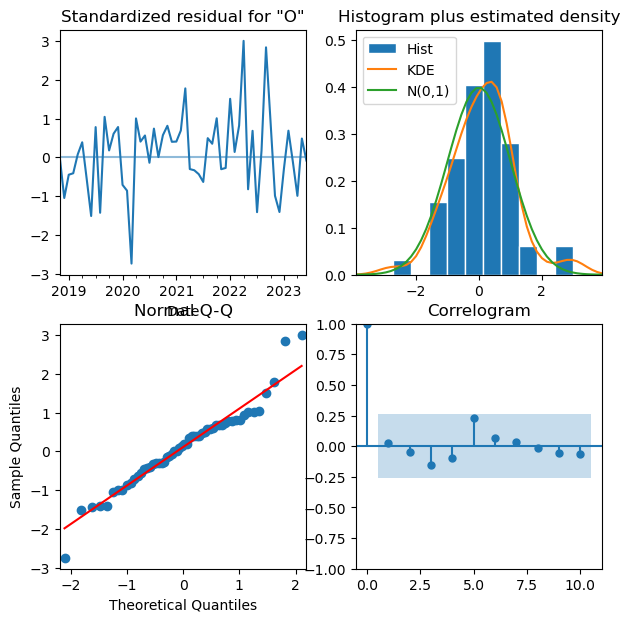

In [317]:
model_bst.plot_diagnostics(figsize= (7,7))
plt.show()

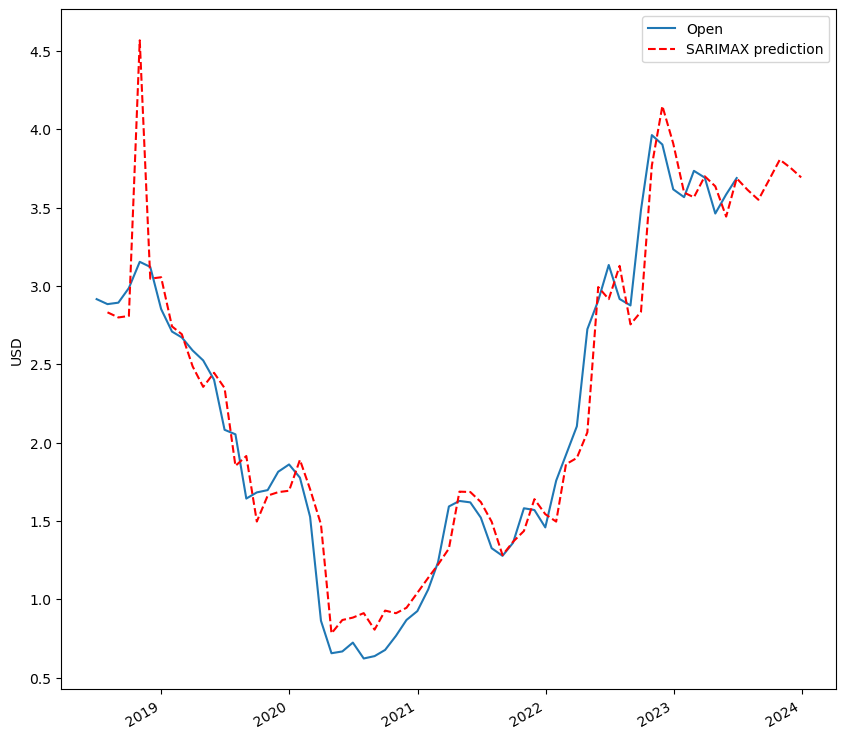

In [335]:
df_mth2 = df_mth[['Open']]
date_list = [datetime(2023,6,30) ,datetime(2023,7,31) ,datetime(2023,8,31) ,datetime(2023,9,30) ,datetime(2023,10,31) ,
             datetime(2023,11,30) ,datetime(2023,12,31)]

future = pd.DataFrame(index=date_list , columns= df_mth.columns)
df_mth2 = pd.concat([df_mth2 , future])

df_mth2['forecast'] = inverseBox(model_bst2.predict(start=datetime(2018,7,31) , end= datetime(2023,12,31)) , lmbda)/1.9

plt.figure(figsize=(10,10))
df_mth2.Open.plot()
df_mth2.forecast.plot(color= 'r' , ls= '--' , label= 'SARIMAX prediction')
plt.legend()
plt.ylabel('USD')
plt.show()

In [331]:
print(df_mth_pred.forecast)

2018-06-30   -0.650000
2018-07-31    3.729144
2018-08-31    3.667099
2018-09-30    3.685135
2018-10-31    7.027794
                ...   
2023-08-31    5.093921
2023-09-30         NaN
2023-10-31         NaN
2023-11-30         NaN
2023-12-31         NaN
Name: forecast, Length: 67, dtype: float64


In [332]:
y_forecasted = df_mth2.forecast
y_truth = df_mth2['2018-6-30': '2023-5-31'].Open

rmse = np.sqrt(((y_forecasted-y_truth)**2).mean())
print('RMSE Error Value:'+str(rmse))

RMSE Error Value:0.2798463662188887
